In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Softmax Classifier exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the Softmax classifier.
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


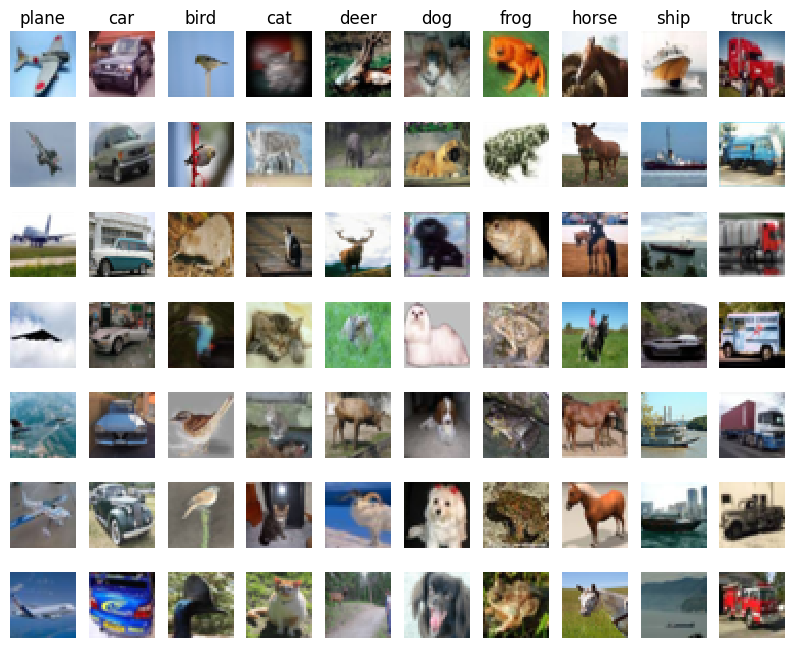

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


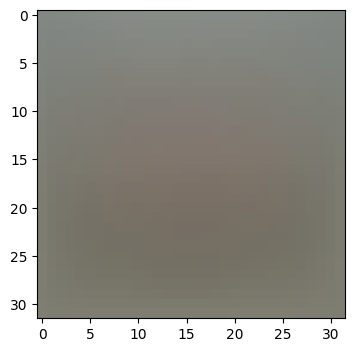

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
# for each image, each pixel gets shifted so that the average pixel value over the dataset is zero
# Why it's important:
# 1. Centering the data: In machine learning, features with a mean near zero help optimization
# algorithms converge faster and avoid numerical issues
# 2. Removes dataset bias: CIFAR-10 images may have an overall average background color.
# For example, if most images are bright, models could be biased toward brighter colors;
# substracting the mean removes the baseline brightness
# 3. Better learning: if the input is centered, the gradient updates are more balanced, especially for methods like gradient descent or SVM
# Analogy: imagine training on faces where most people wear white T_shirts. If you don't
# subtract the mean, the model might waste capacity on detecting whiteness in the lower image instead of actual features
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
# Bias trick -> simplifies model implementation by absorbing the bias term into the weight matrix
# then no need to store and update both W and b separately
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.

As you can see, we have prefilled the function `softmax_loss_naive` which uses for loops to evaluate the softmax loss function.

What is a softmax classifier?

    A softmax classifier is a model that outputs probabilities for each class in a multi-class classification problem.

How it works?

1. Compute class scores: scores = Wx + b
2. Convert scores to probabilities (Softmax function)

   $p_j = \frac{e^{s_j}}{\sum_{k} e^{s_k}}$

3. Loss function (Cross-Entropy Loss)

    * if the correct class is y, we want $p_{y}$ to be as close to 1 as possible

    * L = -log($p_{y}$)

    * if $p_{y}$ is high, then loss is small; if $p_{y}$ is low, loss is large

    * For the dataset with \( N \) examples, the cross-entropy loss is:

    $
    \text{Loss} = -\frac{1}{N} \sum_{i=1}^N \log p_{y_i}
    $

Why it's called softmax?

    instead of picking one, you softly convert all scores into probabilities, the highest still dominates, but all classes get some probability.

In [ ]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# generate a random Softmax classifier weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001
# Training: W starts random -> gradually updated -> becomes a good classifier
# Inference: W is already known -> just used for scoring and picking the class
# so we randomly pick W at initialization
# np.random.randn generates samples from a standard normal distribution

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.346785
loss: 2.346785
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$

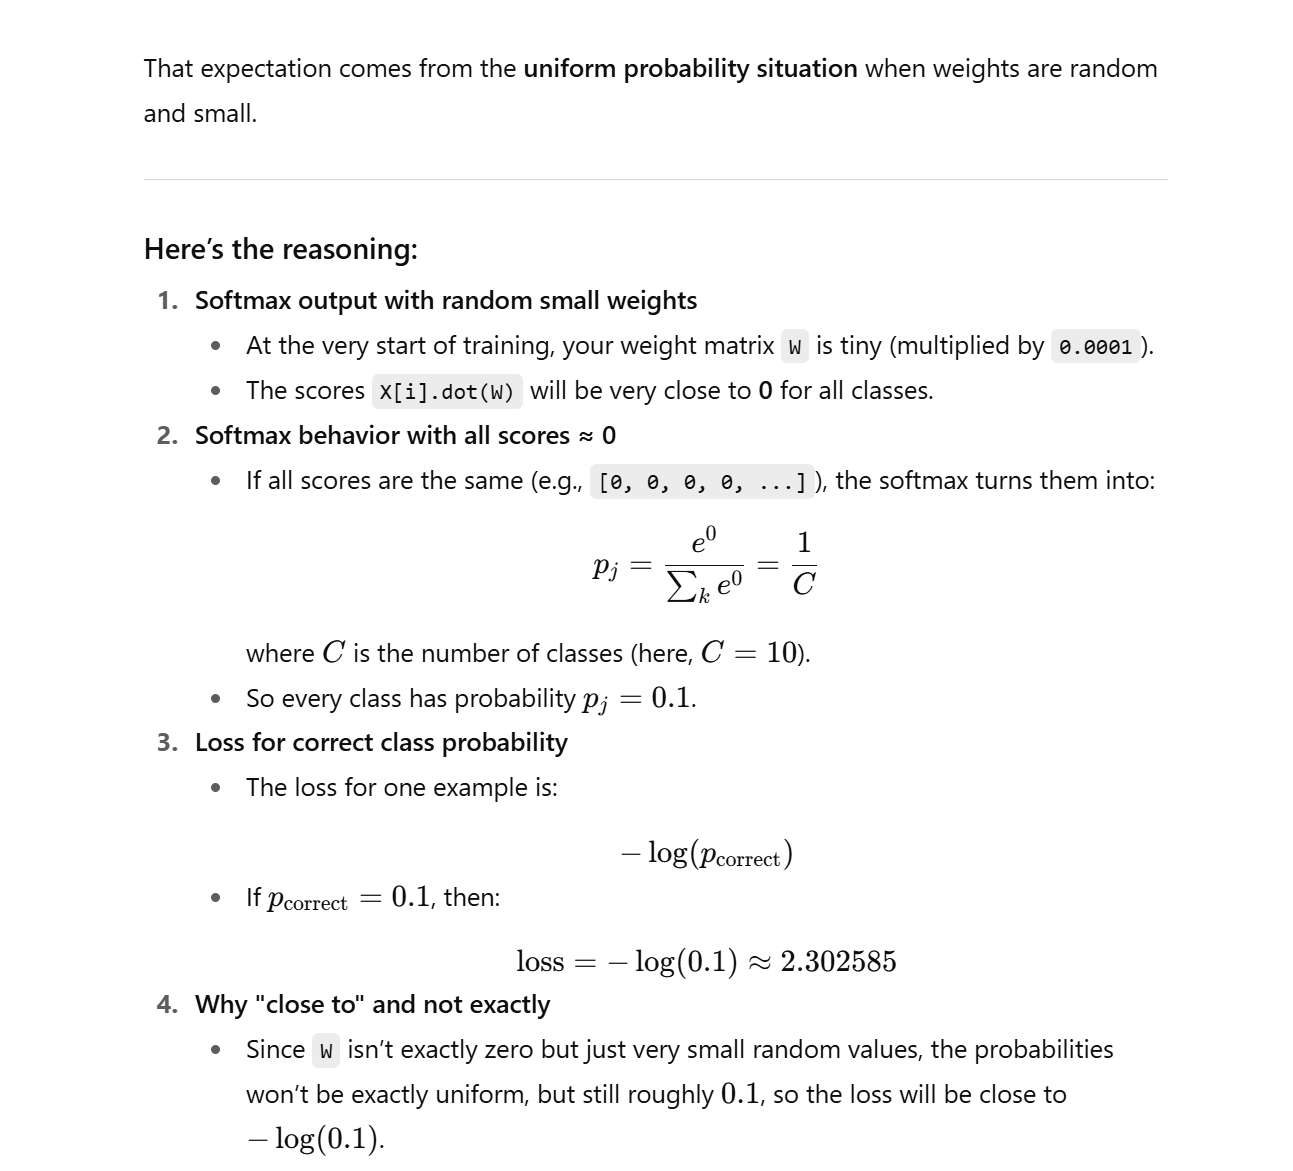

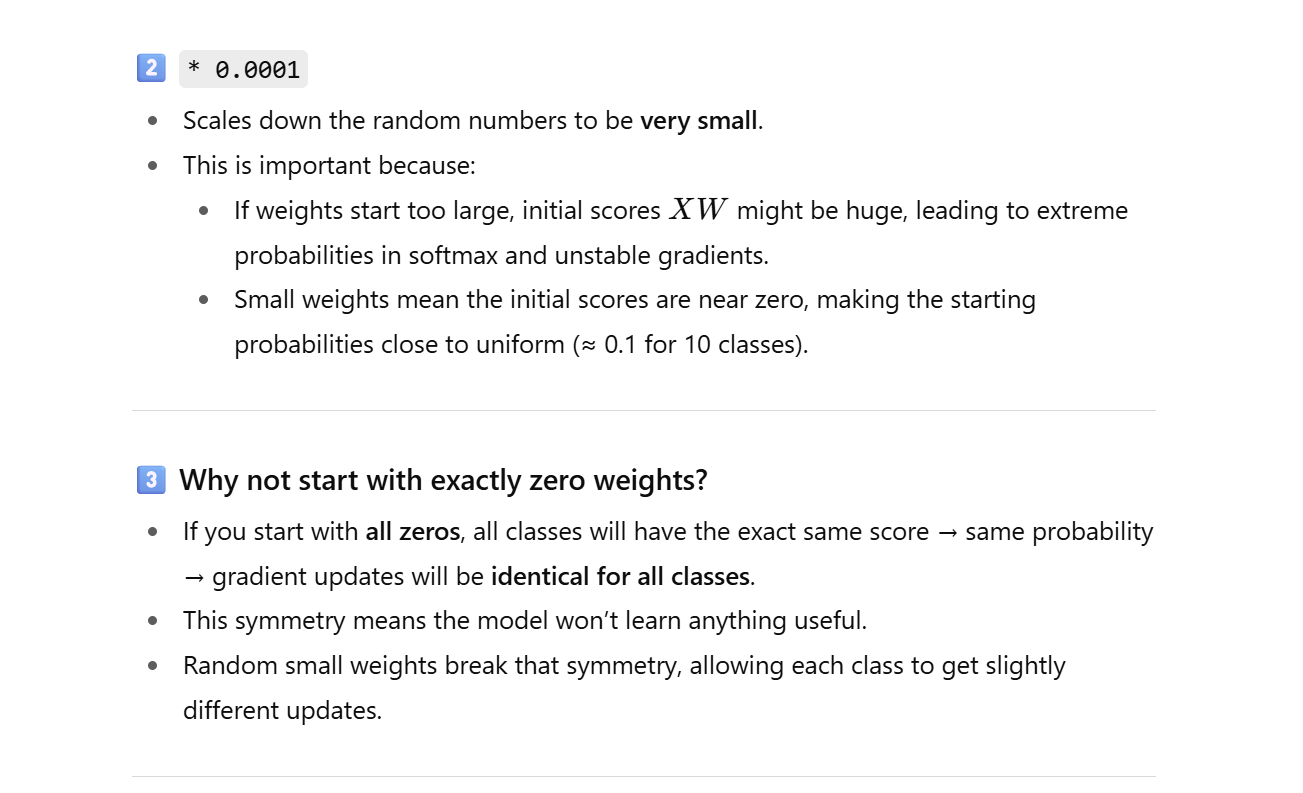


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the softmax loss function and implement it inline inside the function `softmax_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)
# reg = 0
# ensures the core softmax gradient is correct without the complexity of regularization

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)
# ensures you implemented the regularization gradient correctly

numerical: 0.327339 analytic: 0.327339, relative error: 4.922516e-09
numerical: -1.190454 analytic: -1.190454, relative error: 4.888595e-08
numerical: -0.962824 analytic: -0.962824, relative error: 5.599579e-09
numerical: -1.022284 analytic: -1.022284, relative error: 3.083690e-08
numerical: -3.845164 analytic: -3.845164, relative error: 3.130978e-08
numerical: 0.322159 analytic: 0.322159, relative error: 2.108664e-07
numerical: -0.507102 analytic: -0.507102, relative error: 2.671980e-08
numerical: 5.847005 analytic: 5.847005, relative error: 1.702295e-08
numerical: -0.299435 analytic: -0.299435, relative error: 2.511037e-07
numerical: -4.323899 analytic: -4.323899, relative error: 1.717953e-08
numerical: -0.643260 analytic: -0.643260, relative error: 4.002871e-08
numerical: 0.555759 analytic: 0.555759, relative error: 8.390959e-08
numerical: 4.602791 analytic: 4.602791, relative error: 1.156035e-08
numerical: 2.527264 analytic: 2.527264, relative error: 1.822241e-09
numerical: -0.0314

**Inline Question 2**

Although gradcheck is reliable softmax loss, it is possible that for SVM loss, once in a while, a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a svm loss gradient check could fail? How would change the margin affect of the frequency of this happening?

Note that SVM loss for a sample $(x_i, y_i)$ is defined as: $$L_i = \sum_{j\ne y_i}\max(0, s_j - s_{y_i} + \Delta)$$ where $j$ iterates over all classes except the correct class $y_i$ and $s_j$ denotes the classifier score for $j^{th}$ class. $\Delta$ is a scalar margin. For more information, refer to 'Multiclass Support Vector Machine loss' on [this](https://cs231n.github.io/linear-classify/) page.

*Hint: the SVM loss function is not strictly speaking differentiable.*


$\color{blue}{\textit Your Answer:}$

1. What could such a discrepancy be caused by?
  
  Softmax loss is smooth everywhere, it's differentiable for all inputs, that means the numerica gradient will almost exactly match the analytic gradient. Howerver, The SVM loss contains a max function:

  $$
  L_i = \sum_{j \neq y_i} \max\big(0, \; s_j - s_{y_i} + \Delta \big)
  $$

  The max creates a kink. At that exact point, the function is not differentiable. The analytic gradient chooses one side (usually 0 when margin <= 1, or 1 when margin > 0). The numeric gradient from finite differences approximates a symmetric slope(central difference gives ~0.5, which won't match your analytic gradient exacly)

2. Is it a reason for concern?

  If the mismatch happens only when you're on this exact kink, it's not a bug - it's just a property of non-smooth loss functions.

  If mismatches happen far from the kink, it's a bug in your gradient implementation.

3. Simple 1D example

  Take a single hinge function:

  $$
    L(x) = max(0,x)
  $$

  at x=0, the function is not differentiable, then the analytic gradient might be 0, and numeric gradient would be 0.5. That's the kind of mismatch you can get in SVM gradcheck.

4. How margin affects mismatch frequency?

  Changing $Δ$ shifts the location of the kinks. On the one hand, larger $Δ$ makes the kink move further into the score space, then more points may land exactly on a kink, more frequent mismatches. On the other hand, smaller $Δ$ makes fewer scores land exactly ong the boundary, then fewer mismatches

In [ ]:
# Next implement the function softmax_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.346785e+00 computed in 0.061212s
Vectorized loss: 2.346785e+00 computed in 0.030768s
difference: -0.000000


In [ ]:
# Complete the implementation of softmax_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.056005s
Vectorized loss and gradient: computed in 0.009149s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 770.712423
iteration 100 / 1500: loss 282.599705
iteration 200 / 1500: loss 104.752987
iteration 300 / 1500: loss 39.640702
iteration 400 / 1500: loss 15.760274
iteration 500 / 1500: loss 7.124999
iteration 600 / 1500: loss 3.917557
iteration 700 / 1500: loss 2.732083
iteration 800 / 1500: loss 2.289103
iteration 900 / 1500: loss 2.174465
iteration 1000 / 1500: loss 2.150878
iteration 1100 / 1500: loss 2.105418
iteration 1200 / 1500: loss 2.037119
iteration 1300 / 1500: loss 2.013921
iteration 1400 / 1500: loss 2.157700
That took 9.218825s


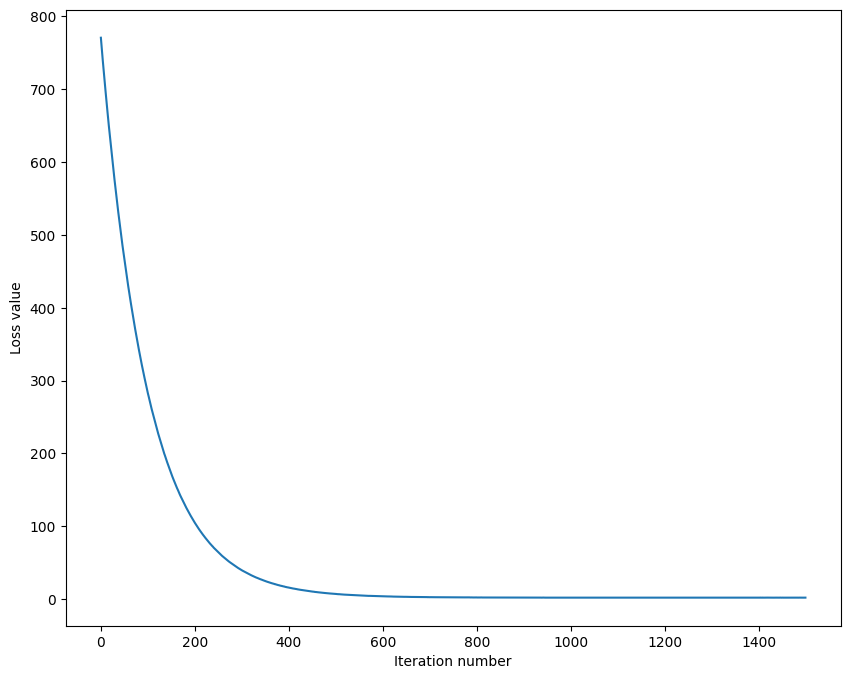

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearClassifier.predict function and evaluate the performance on
# both the training and validation set
# You should get validation accuracy of about 0.34 (> 0.33).
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.328367
validation accuracy: 0.352000


In [ ]:
# Save the trained model for autograder.
softmax.save("softmax.npy")

softmax.npy saved.


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.365 (> 0.36) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a Softmax on the.        #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this.   #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train; once  #
# you are confident that your validation code works, you should rerun the      #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6]
regularization_strengths = [2.5e4, 1e4]

# Loop over all combinations of hyperparameters
for lr in learning_rates:
  for reg in regularization_strengths:
    # initialize a new softmax classifier
    softmax = Softmax() # replace with your class name if different
    softmax.train(X_train, y_train, learning_rate = lr,reg = reg, num_iters=200)

    # predict on training and validation sets
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)

    train_accuracy = np.mean(y_train_pred == y_train)
    val_accuracy = np.mean(y_val_pred == y_val)

    results[(lr, reg)] = (train_accuracy, val_accuracy)

    if val_accuracy > best_val:
      best_val = val_accuracy
      best_softmax = softmax

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.176184 val accuracy: 0.167000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.194347 val accuracy: 0.207000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.345653 val accuracy: 0.362000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.322796 val accuracy: 0.336000
best validation accuracy achieved during cross-validation: 0.362000


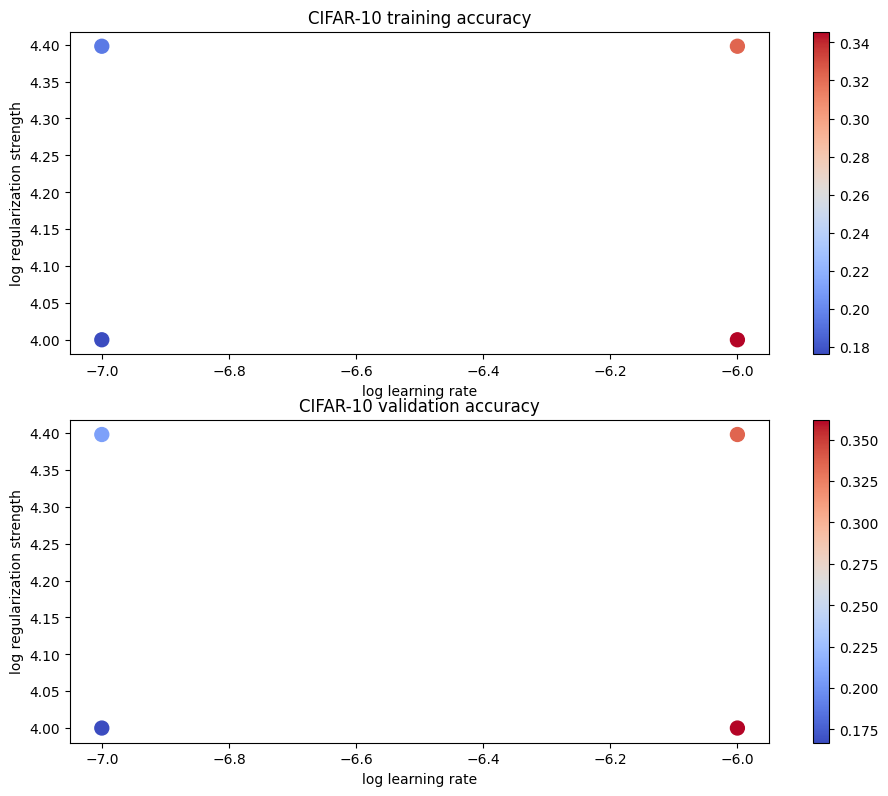

In [ ]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.342000


In [ ]:
# Save best softmax model
best_softmax.save("best_softmax.npy")

best_softmax.npy saved.


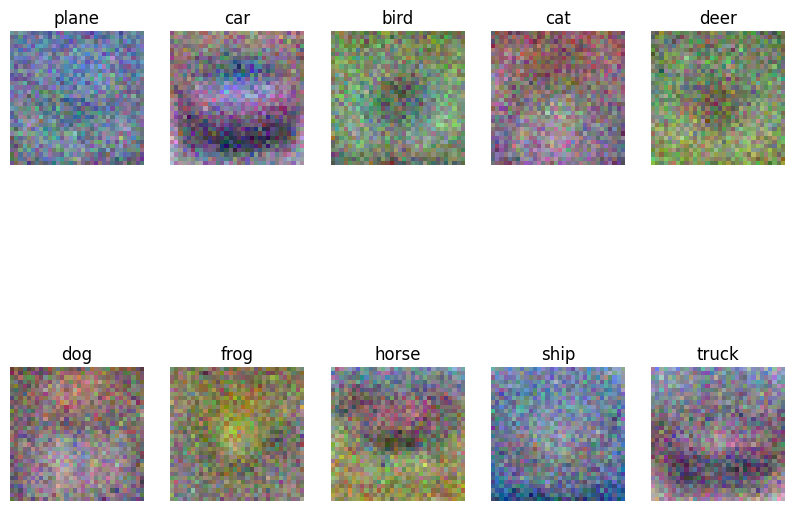

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 3**

Describe what your visualized Softmax classifier weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$

The visualized weight images for each class appear noisy and colorful, without clear object shapes. This occurs because the Softmax classifier is linear and assigns a weight to each input pixel independently, so it cannot capture complex spatial structures. The colors indicate which pixels contribute positively or negatively to each class's score. With more advanced models like CNNs, we would expect the visualizations to show more structured patterns resenbling the actual objects.


**Inline Question 4** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would change the softmax loss, but leave the SVM loss unchanged.

$\color{blue}{\textit Your Explanation:}$

This statement is true.

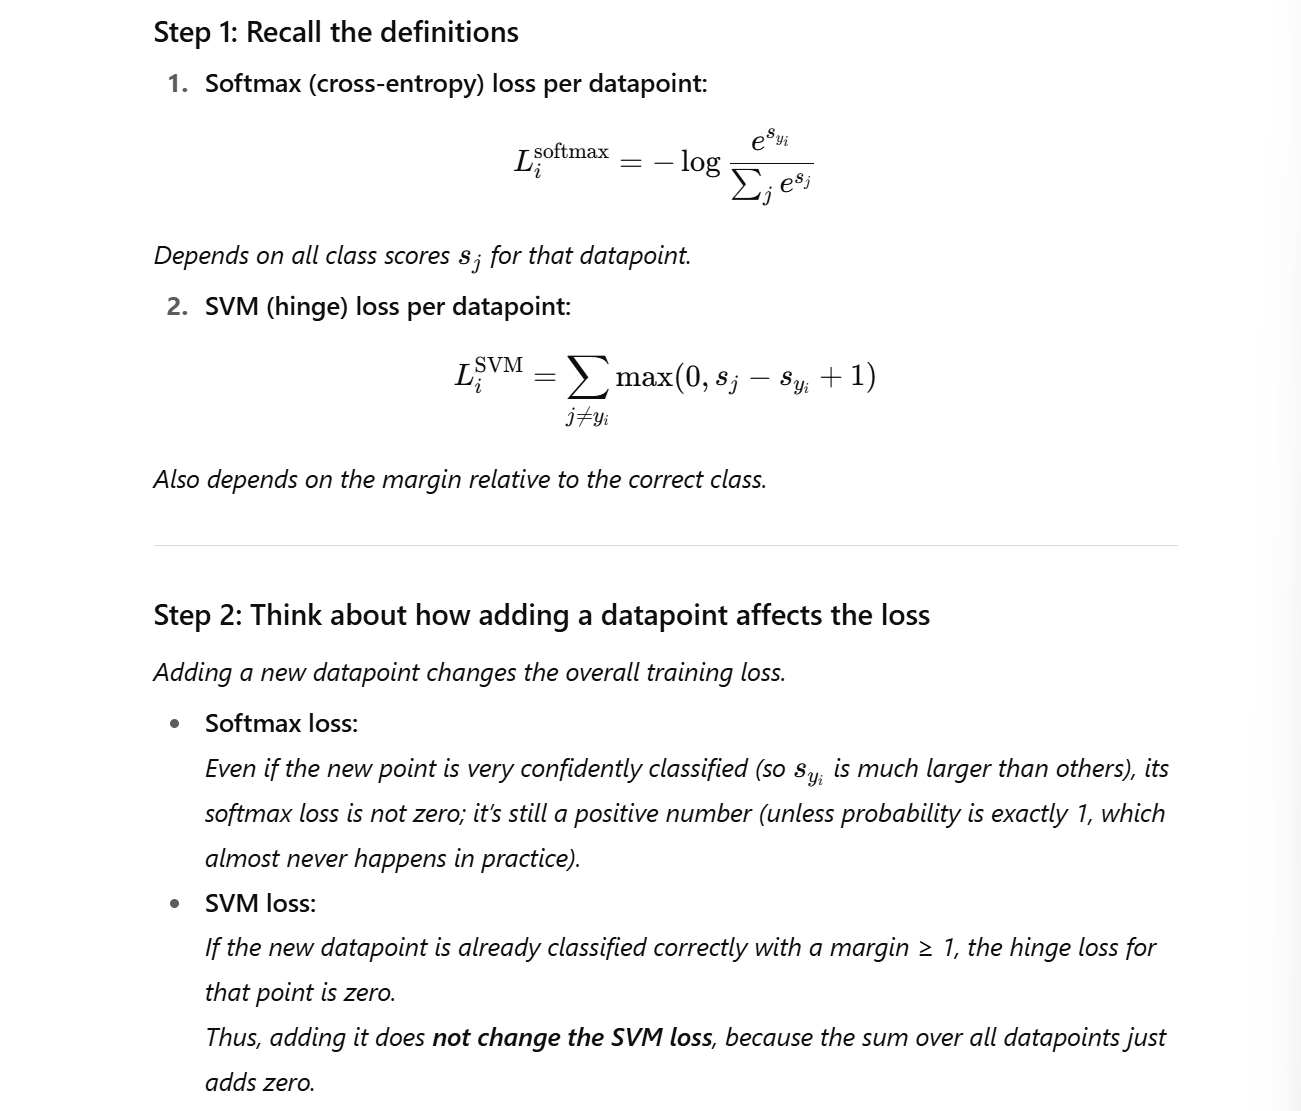

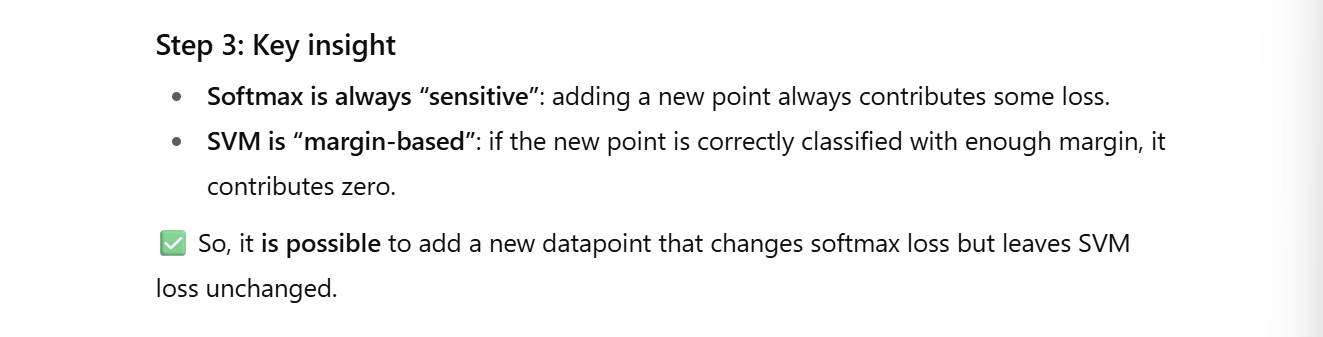